This functions allows to create a signal of constituent frequencies

Of the two main frequency components of HRV, namely low-frequency (LF, 0.04-0.15 Hz) and high-frequency (HF, 0.15-0.4 Hz) components.

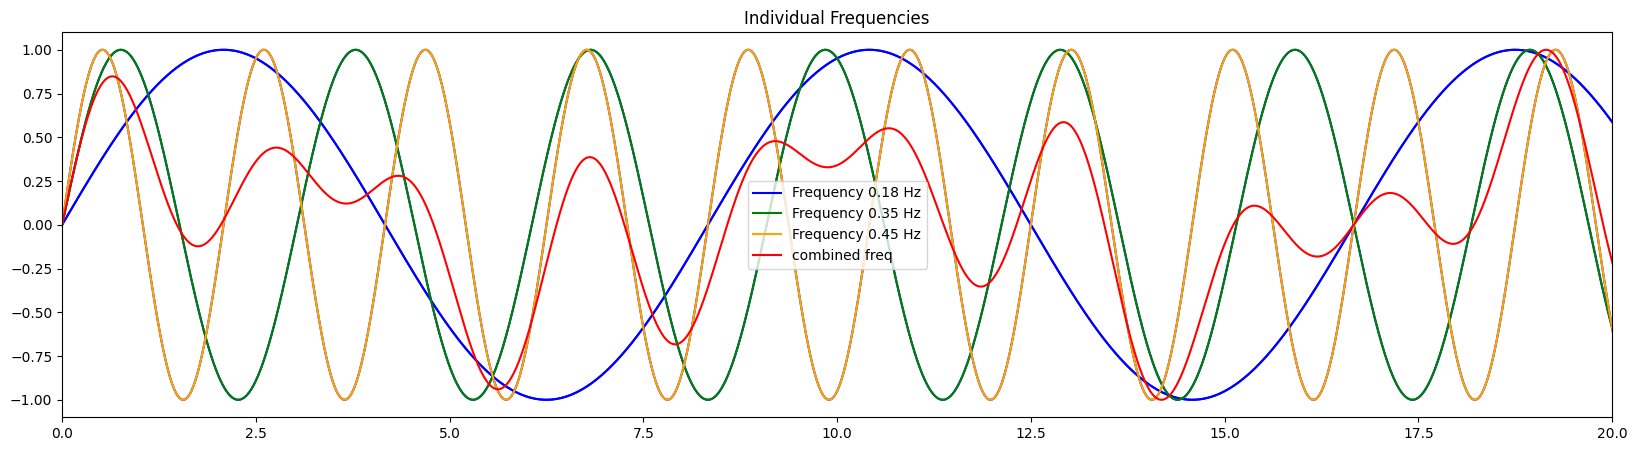

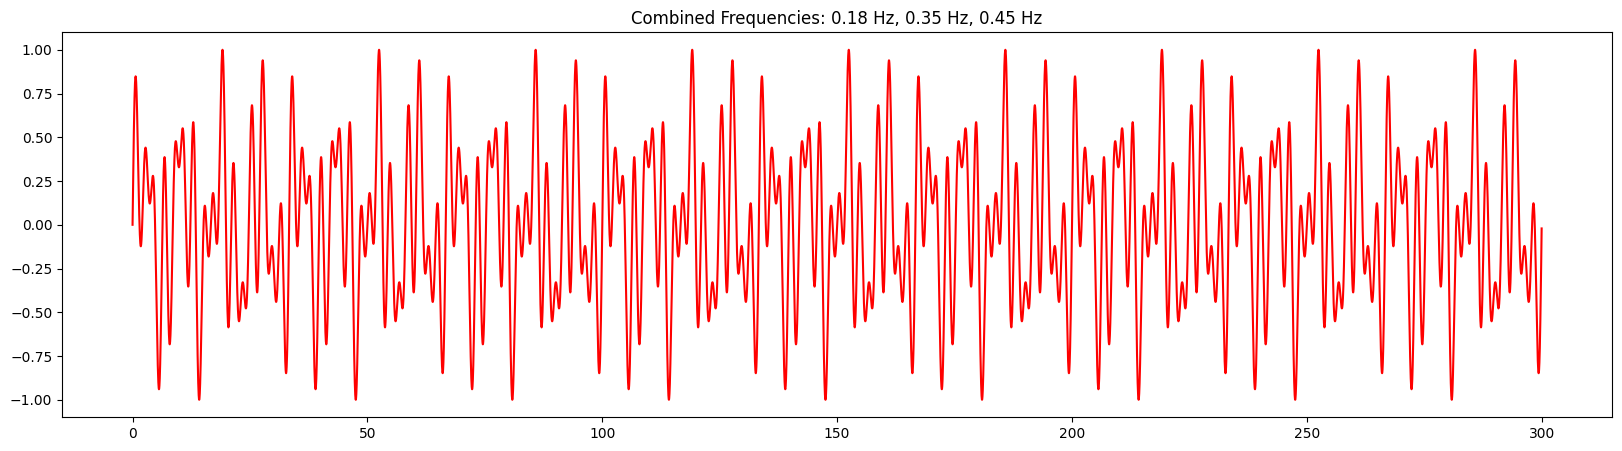

In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

plt.rcParams['figure.figsize'] = [20, 5]

def create_frequency(freq:float, magnitude:float =1, sampling_freq = 100):
    "Creates 5 minutes of signal"
    t = np.arange(0, 300, 1/sampling_freq)
    signal = pd.Series(magnitude * np.sin(2 * np.pi * freq * t), index= pd.Index(t, name='Time'))
    plt.plot(signal, color='blue')
    signal = signal - signal.mean()
    return signal

plt.xlim(0, 20)

# Create and plot individual frequencies
freq1 = create_frequency(0.12, 1)
freq2 = create_frequency(0.33, 1)
freq3 = create_frequency(0.48, 1)

signal = freq1 + freq2 + freq3
signal = signal / signal.max()


# Combine frequencies and plot the resulting signal
plt.plot(freq1, label='Frequency 0.18 Hz', color='blue')
plt.plot(freq2, label='Frequency 0.35 Hz', color='green')
plt.plot(freq3, label='Frequency 0.45 Hz', color='orange')
plt.plot(signal,label='combined freq', color='r')
plt.legend()
plt.title('Individual Frequencies')
plt.show()

# Combine frequencies and plot the resulting signal

plt.plot(signal, color='r')
plt.title('Combined Frequencies: 0.18 Hz, 0.35 Hz, 0.45 Hz')
plt.show()




Note that the very act of using a digital system introduces high frequency components in fft
My own class to simplify plotting singal and its psd

In [70]:
def signal_to_PSD(signal, sampling_freq = 100):
    fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(fft), 1/sampling_freq)

    PSD = pd.Series(abs(fft)**2, index=freq, name='Energy')
    PSD.index.name = 'Frequency'
    return PSD

def sinc_interpolate(signal:pd.Series):
    T = (signal.index.max()-signal.index.min())/len(signal)
    constant_grid = np.arange(len(signal)) * T
    interpolated = pd.Series(0, index=constant_grid)
    for point, magnitude in signal.items():
        interpolated += magnitude * np.sinc((point-constant_grid) / T)
    return interpolated

def sinc_and_psd(signal):
    signal = sinc_interpolate(signal)
    return signal_to_PSD(signal, 1/(signal.index[1]- signal.index[0]))



My own class to simplify plotting singal and its psd

In [ ]:
class SignalPlotter:
    def __init__(self):
        self.fig, self.axs = plt.subplots(2, 1, figsize=(20, 10))

    def plot_signal_and_psd(self, signal: pd.Series, psd: pd.Series, label: str, color: str):
        """Plots the same signal and psd on initiated set of axes"""
        # Plot the signal
        sns.lineplot(ax=self.axs[0], x=signal.index, y=signal.values, label=label, color=color, alpha=0.8)
        self.axs[0].set_xlim((0, 100))
        self.axs[0].set_title(f'{label} Signal')
        self.axs[0].legend()

        # Plot the PSD of the signal
        sns.lineplot(ax=self.axs[1], x=psd.index, y=psd.values / psd.max(), label=f'{label} PSD', color=color, alpha=0.8)
        self.axs[1].set_xlim((0, 0.5))
        self.axs[1].xaxis.set_major_locator(plt.MultipleLocator(0.1))
        self.axs[1].grid(True)
        self.axs[1].set_title(f'PSD of {label}')
        self.axs[1].legend()

Randomly resample the signal and look into psd

I will now implement Sinc (Whitetaker-Shanon interpolation):

Altough, Sinc (whitetaker-Shanon) interpolation distorsts the signal in the time domain. Normalized PSD is identical to the orginal signal.

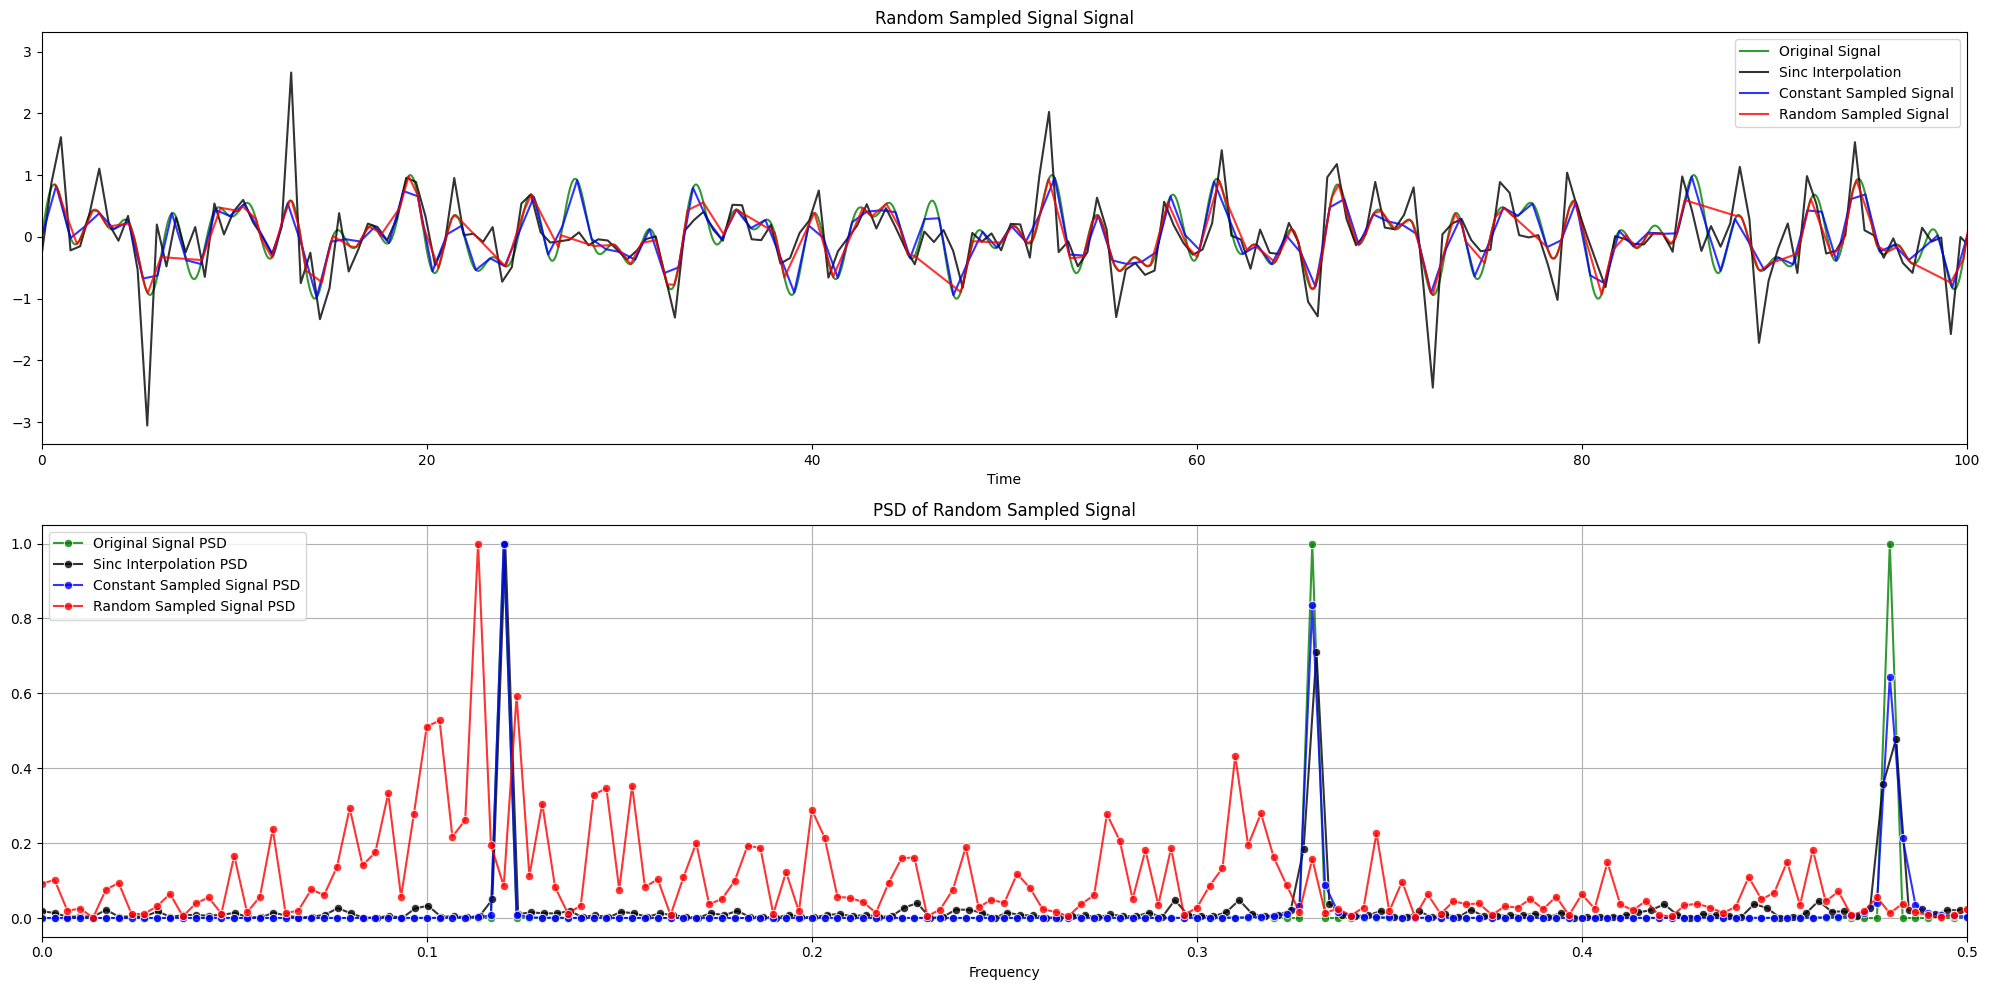

<Figure size 2000x500 with 0 Axes>

In [72]:
signal=signal
original_psd = signal_to_PSD(signal, 100)

indices = np.linspace(0, len(signal) - 1, 400, dtype=int)
sampled_signal = signal.iloc[indices]
psd_sampled = signal_to_PSD(sampled_signal,400/300)

random_sample = signal.sample(n=600, random_state=1).sort_index()
psd_random = signal_to_PSD(random_sample,2)
            
sinc_signal = sinc_interpolate(random_sample)
sinc_psd = sinc_and_psd(random_sample)

plotter = SignalPlotter()

# Plot signals
plotter.plot_signal_and_psd(signal, original_psd, 'Original Signal', 'green')
plotter.plot_signal_and_psd(sinc_signal, sinc_psd, 'Sinc Interpolation', 'black')
plotter.plot_signal_and_psd(sampled_signal, psd_sampled, 'Constant Sampled Signal', 'blue')
plotter.plot_signal_and_psd(random_sample, psd_random, 'Random Sampled Signal', 'red')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

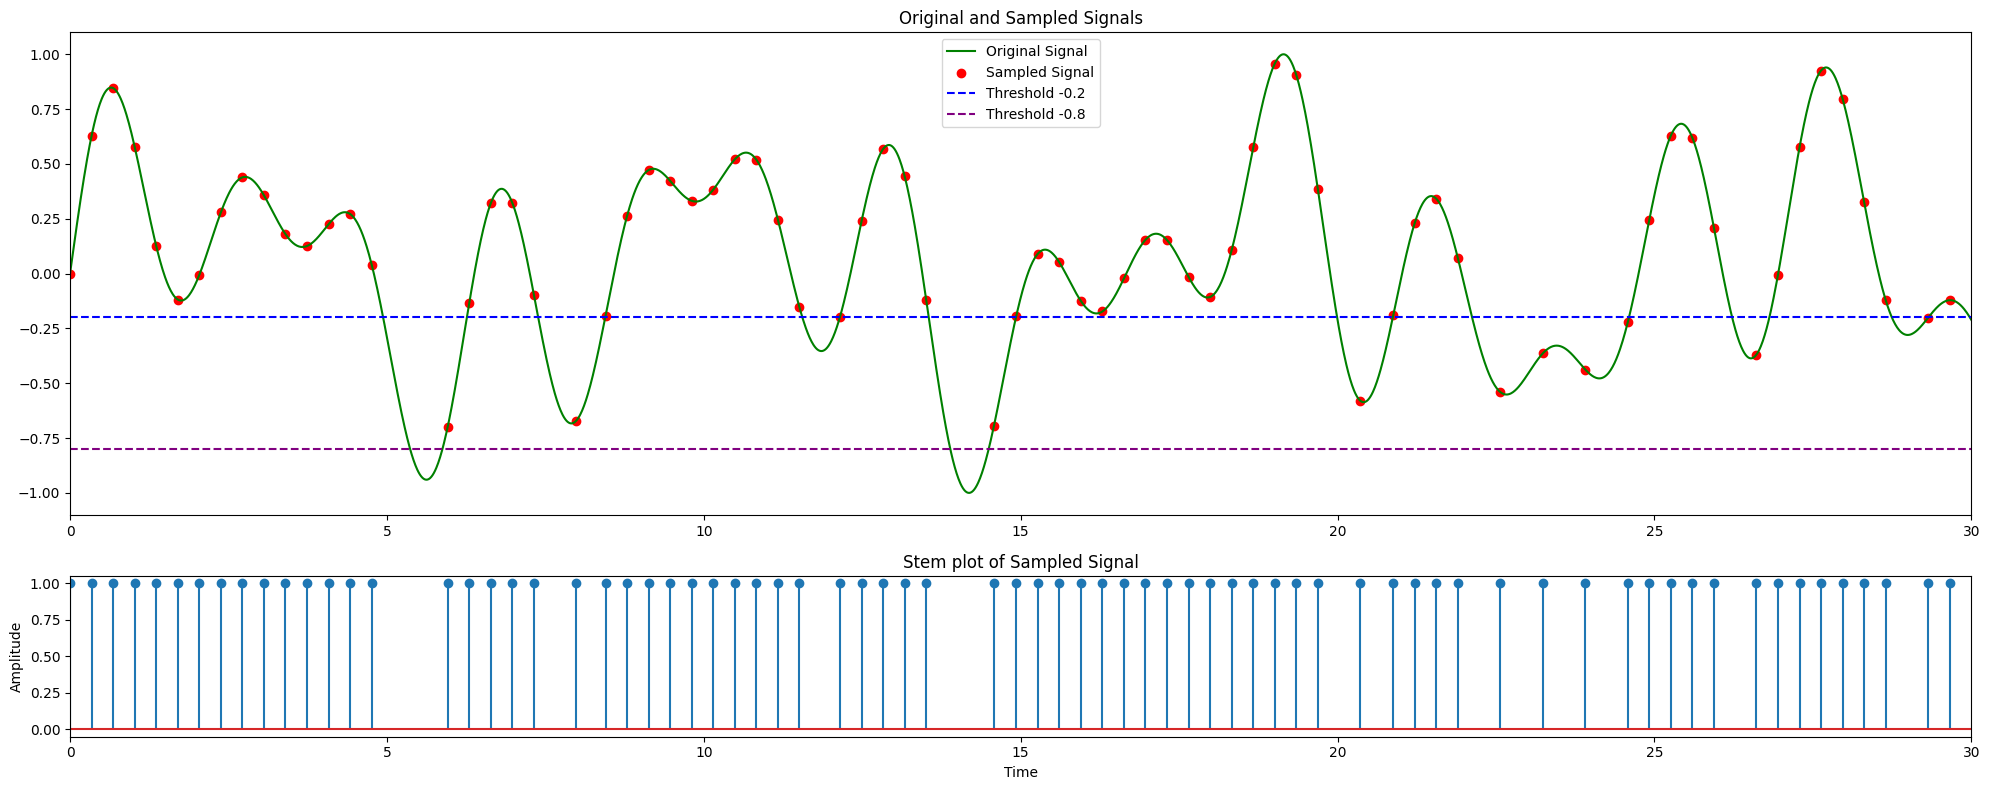

In [73]:
sampling_freq = 100
sampled_signal = pd.Series(dtype=float)
last_sample_time = -10  # Initialize to a value that ensures the first sample can be taken
inactive_refractive_freq = 3
active_refractive_freq = 3

for time, value in signal.items():
    if value > -0.2 and ((time - last_sample_time) >= 1/inactive_refractive_freq ):
        sampled_signal.at[time] = value
        last_sample_time = time
    elif value > -0.7 and ((time - last_sample_time) >= 1/inactive_refractive_freq  +1/active_refractive_freq ):
        sampled_signal.at[time] = value
        last_sample_time = time

fig, axs = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [3, 1]})

# Plot the original and sampled signals
axs[0].plot(signal, label='Original Signal', color='green')
axs[0].scatter(sampled_signal.index, sampled_signal.values, color='red', label='Sampled Signal')
axs[0].set_xlim(0, 30)
axs[0].legend()
axs[0].set_title('Original and Sampled Signals')

# Plot the stem plot of the sampled signal
axs[1].stem(sampled_signal.index, np.ones_like(sampled_signal.values))
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Stem plot of Sampled Signal')
axs[1].set_xlim(0, 30)

# Draw horizontal lines at -0.2 and -0.8
axs[0].axhline(y=-0.2, color='blue', linestyle='--', label='Threshold -0.2')
axs[0].axhline(y=-0.8, color='purple', linestyle='--', label='Threshold -0.8')
axs[0].legend()

plt.tight_layout()
plt.show()

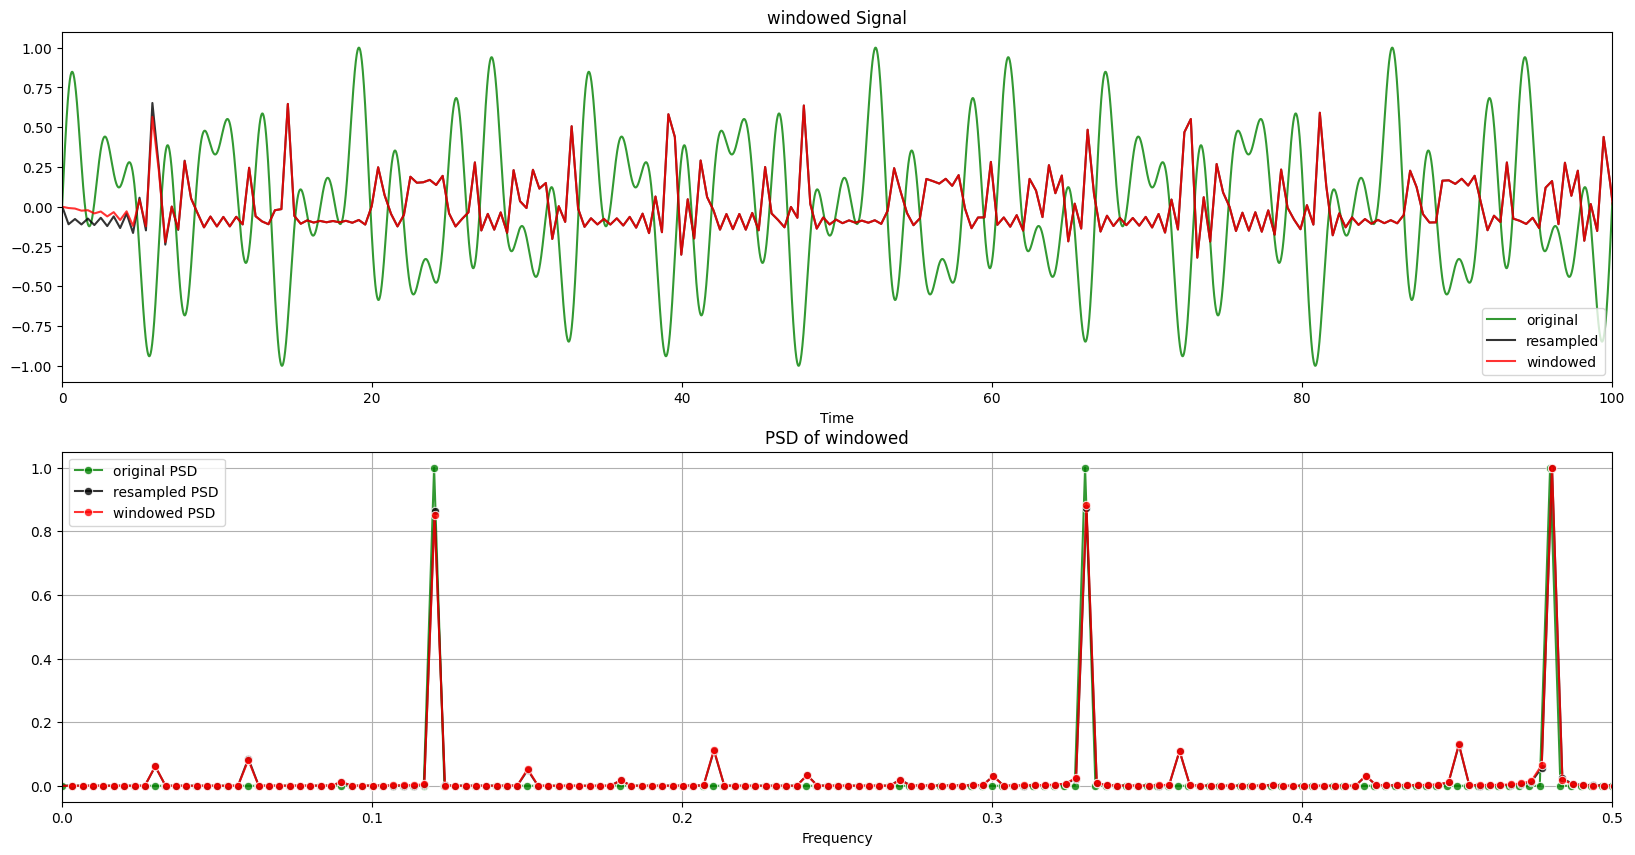

In [74]:
def create_HRV_and_psd(sampled_signal)->tuple[pd.Series, pd.Series, pd.Series]:
    HRV = pd.Series(sampled_signal.index.diff(), index=sampled_signal.index).dropna()
    HRV = HRV - HRV.mean()
    resampled_HRV = sinc_interpolate(HRV)
    HRV_sampling_freq = 1 / resampled_HRV.index.diff()
    resampled_psd = signal_to_PSD(resampled_HRV, HRV_sampling_freq)
    return HRV, resampled_HRV, resampled_psd


original_psd = signal_to_PSD(signal, 100)
HRV, resampled_HRV, resampled_psd = create_HRV_and_psd(sampled_signal)



simulation_test = SignalPlotter()
simulation_test.plot_signal_and_psd(signal, original_psd, 'original', 'green')
simulation_test.plot_signal_and_psd(resampled_HRV, resampled_psd, 'resampled', 'black')


#Apply sin(X) windowing to the signal
windowed_signal = resampled_HRV
window_length = len(windowed_signal) // 16
subwindow1 = np.sin(np.linspace(0, np.pi / 2, window_length // 2))
subwindow2 = np.sin(np.linspace(np.pi / 2, np.pi, window_length // 2))

windowed_signal.iloc[:len(subwindow1)] *= subwindow1
windowed_signal.iloc[-len(subwindow2):] *= subwindow2

#plt.show()
#sns.lineplot(windowed_signal)
#sns.lineplot(resampled_HRV)

HRV_sampling_freq = 1 / resampled_HRV.index.diff()
windowed_psd = signal_to_PSD(windowed_signal, HRV_sampling_freq)



simulation_test.plot_signal_and_psd(windowed_signal, windowed_psd, 'windowed', 'red')




<Axes: >

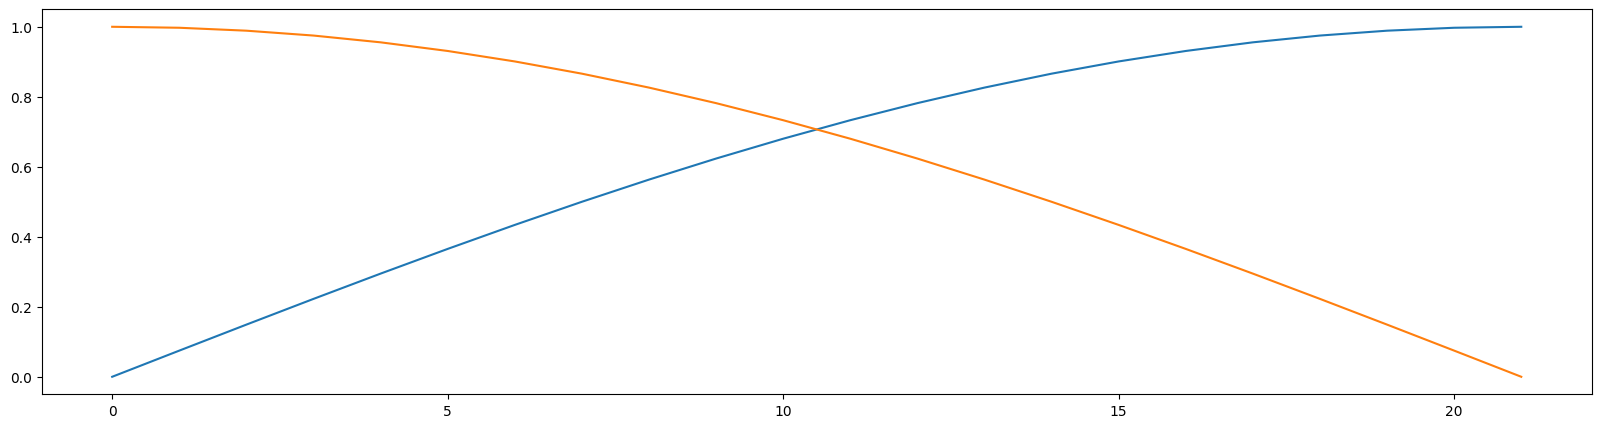

In [75]:

# Apply sinx windowing to 1/8th of the signal


sns.lineplot(subwindow1)
sns.lineplot(subwindow2)

Following text lists the attempts of achieving the same using local maxima and minima. It is quite useless.

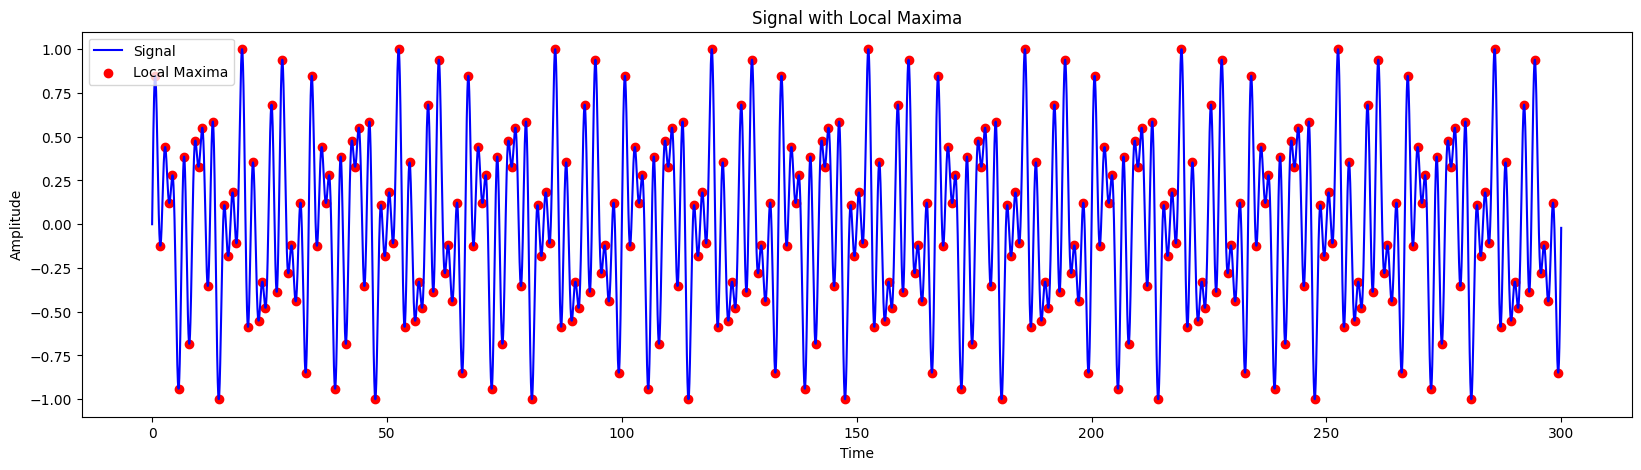

In [76]:
def find_peaks(signal):
    local_maxima = signal[(signal.shift(1) < signal) & (signal.shift(-1) < signal)]
    local_minima = signal[(signal.shift(1) > signal) & (signal.shift(-1) > signal)]
    peaks = pd.concat([local_maxima, local_minima]).sort_index()
    return peaks

peaks = find_peaks(signal)

plt.figure(figsize=(20, 5))
plt.plot(signal, label='Signal', color='blue')
plt.scatter(peaks.index, peaks.values, color='red', label='Local Maxima')
plt.title('Signal with Local Maxima')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.show()

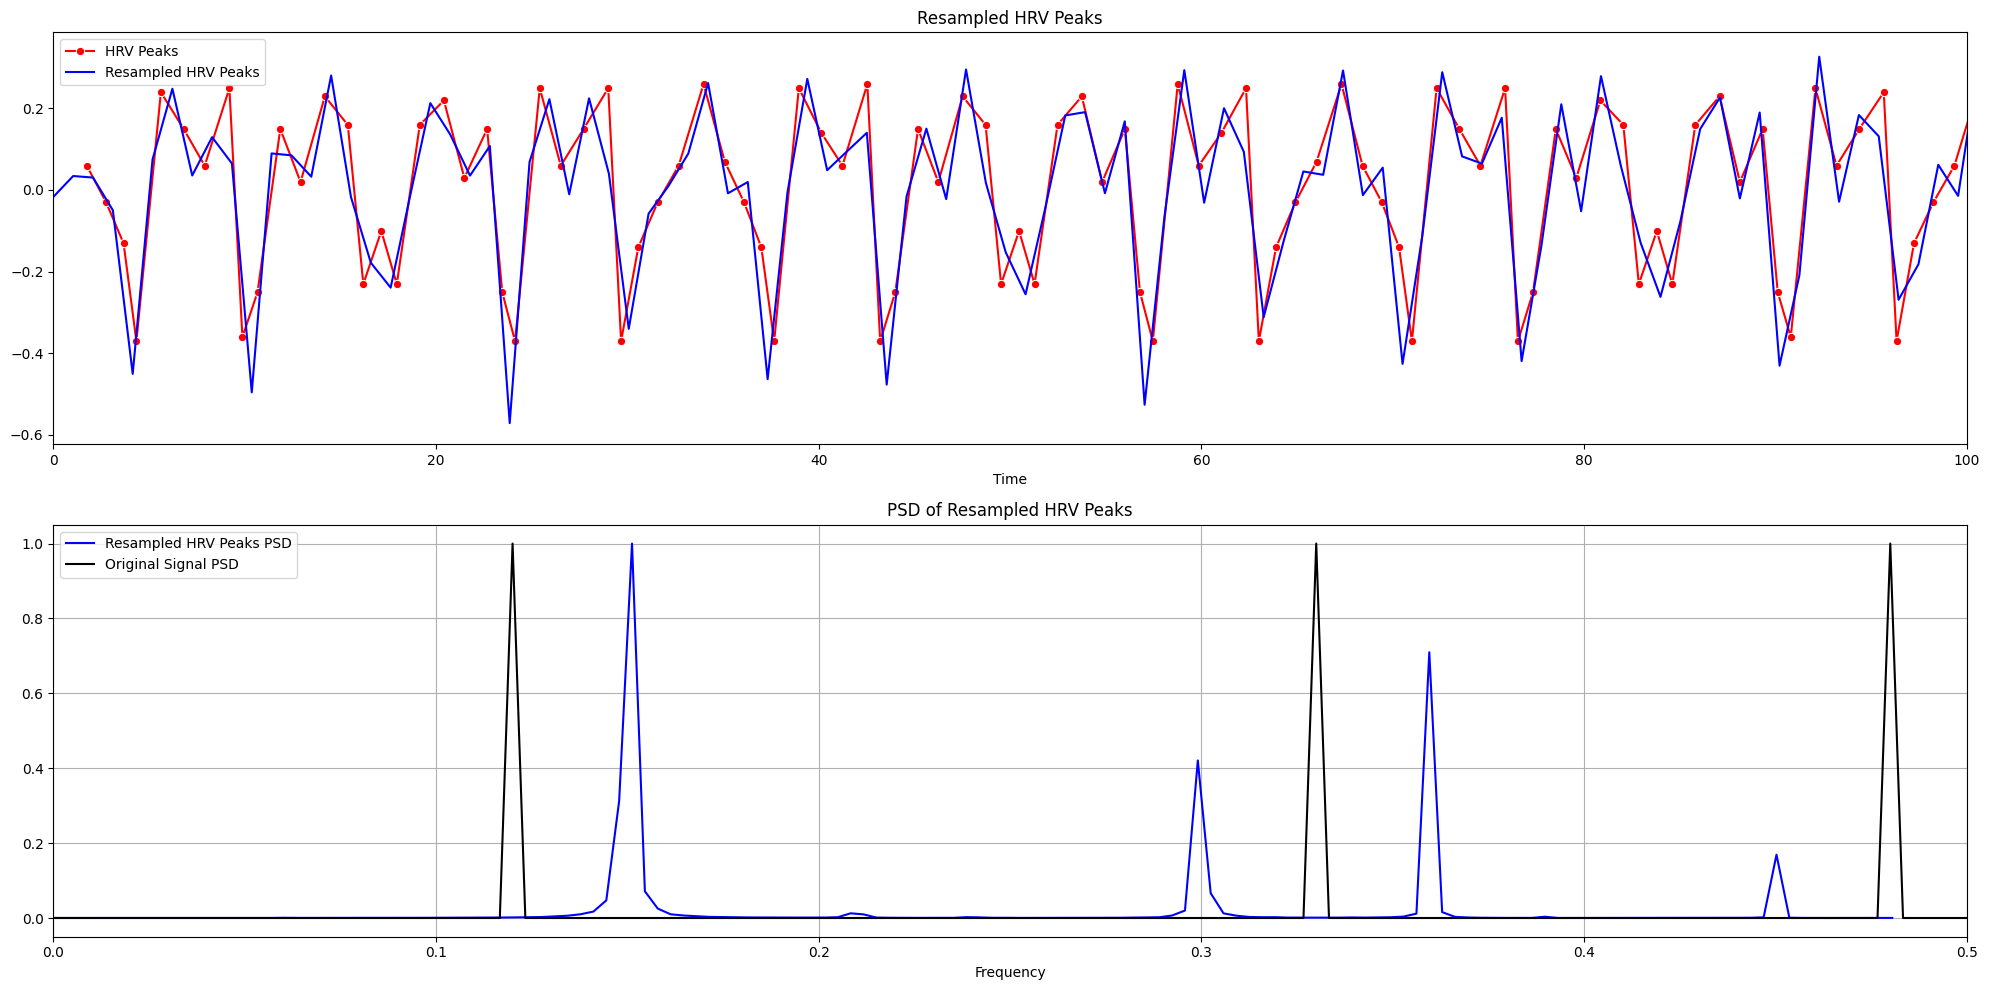

In [77]:


HRV_peaks, resampled_HRV_peaks, resampled_psd_peaks = create_HRV_and_psd(peaks)

# Plot the resampled signal and its PSD for peaks
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# Plot the resampled signal
sns.lineplot(ax=axs[0], x=HRV_peaks.index, y=HRV_peaks.values, color='red', label='HRV Peaks', marker='o')
sns.lineplot(ax=axs[0], x=resampled_HRV_peaks.index, y=resampled_HRV_peaks.values, label='Resampled HRV Peaks', color='blue')
axs[0].set_xlim((0, 100))
axs[0].set_title('Resampled HRV Peaks')
axs[0].legend()

# Plot the PSD of the resampled signal
sns.lineplot(ax=axs[1], x=resampled_psd_peaks.index, y=resampled_psd_peaks.values/ resampled_psd_peaks.values.max(), label='Resampled HRV Peaks PSD', color='blue')
sns.lineplot(ax=axs[1], x=original_psd.index, y=original_psd.values/original_psd.max(), label='Original Signal PSD', color='black')
axs[1].set_xlim((0, 0.5))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[1].grid(True)
axs[1].set_title('PSD of Resampled HRV Peaks')
axs[1].legend()

plt.tight_layout()
plt.show()